#  Open Source LLMs: Getting Started

### Goal: Start generating text in the next 120 seconds

**By: Glenn Parham (Defense Digital Services)**

## Getting Started

In this colab notebook, we'll want to use a **T4** GPU (A100/V100 will also work).  You may switch to this by going to "Runtime" then "Change Runtime Type"

This accelerated GPU will ensure inference of LLMs will not take forever.

Let's verify you're using a T4.  Once you run this cell, you should get the following output (if you're not, skip this cell):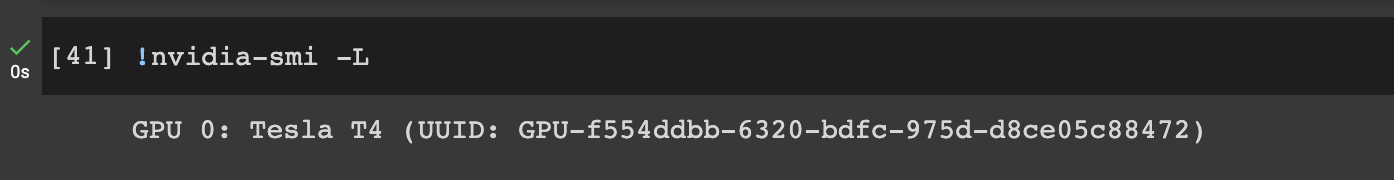

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3a6ac369-386e-5868-0614-bf55da43c9f2)


To get around annoying text-wrapping issues, run this cell.

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## Installing Dependencies

You'll need to install the following requirements

Python Libraries
- HuggingFace
- Llama-cpp-python

In [ ]:
## INSTALLING HUGGINGFACE
!pip install huggingface-hub==0.17.1 -q

## INSTALLING llama-cpp-python
# GPU llama-cpp-python; Starting from version llama-cpp-python==0.1.79, it supports GGUF
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --upgrade --no-cache-dir


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 21.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 188.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 225.6 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.2.11-cp310-cp310-manylinux_2_35_x86_64.whl size=6423740 sha256=742c837ef8a9754162d324c932cf7fb20adf5215f70c60779525851a9efaa19a
  Stored in directory: /tmp/pip-ephem-wheel-cache-lla1jccd/wheels/dc/42/77/a3ab0d02700427ea364de5797786c0272779dce795f62c3bc2
Successfully built llama-cpp-python
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
   

Next, you'll need to download the model weights from HuggingFace.

Here's a list of models you can choose from: https://huggingface.co/models?pipeline_tag=text-generation&sort=trending&search=GGUF

Note: The model you select **must** be of type "GGUF"

GGUF is...
- binary file format for storing models for inference
- designed for fast loading and saving of models
- easy to use (with a few lines of code)
- mmap (memory mapping) compatibility: models can be loaded using mmap for fast loading and saving.

In [ ]:
# @title Select Large Language Model
selected_llm = 'Mistral-7B-OpenOrca' # @param ["Mistral-7B", "Mistral-7B-OpenOrca", "Llama-2-13B-Chat"]

model_dic = {"Mistral-7B":{"HF_REPO_NAME":"TheBloke/Mistral-7B-Instruct-v0.1-GGUF","HF_MODEL_NAME":"mistral-7b-instruct-v0.1.Q4_K_M.gguf"},
           "Mistral-7B-OpenOrca":{"HF_REPO_NAME":"TheBloke/Mistral-7B-OpenOrca-GGUF","HF_MODEL_NAME":"mistral-7b-openorca.Q5_K_M.gguf"},
             "Llama-2-13B-Chat":{"HF_REPO_NAME":"TheBloke/Llama-2-13B-chat-GGUF","HF_MODEL_NAME":"llama-2-13b-chat.Q4_K_S.gguf"}
             }

In [ ]:
import os

from huggingface_hub import hf_hub_download


HF_REPO_NAME = model_dic[selected_llm]['HF_REPO_NAME']
HF_MODEL_NAME = model_dic[selected_llm]['HF_MODEL_NAME']
LOCAL_DIR_NAME = "models"

os.makedirs(LOCAL_DIR_NAME, exist_ok=True)
model_path = hf_hub_download(
    repo_id=HF_REPO_NAME, filename=HF_MODEL_NAME, local_dir=LOCAL_DIR_NAME
)

Now, let's initialize the "Llama" framework.

So this is a bit messy.  Llama-cpp was named after Meta's open-source "*Llama*" LLMs.  The framework was built to make it easy to locally run & program with this LLM.  However, now, the framework as been abstracted and modified to work with ***any*** open-source text-generation LLM, as long as it is in the GGUF model file type.

In our case, we are using the Mistral open-source LLM and Llama-cpp as our framework.

In [ ]:
from llama_cpp import Llama

llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=30, # The max for this model is 30 in a T4, If you use llama 2 70B, you'll need to put fewer layers on the GPU
    n_ctx=4096, # Context window
)


AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


# The Fun Part

You're all ready to actually use this LLM!  Feel free to change the prompt variable to whatever you'd like.  Once you run the cell, it'll begin to stream the generated text.  The speed will depend on the GPU you selected (T4 vs. V100).

In [ ]:
prompt = """
What is the US Department of Defense?
"""

In [ ]:
response = llm(prompt,stream=True,stop=["\n\n"],temperature=0, max_tokens=200)
generated_text = ""
for output in response:
    result = output['choices'][0]['text']
    generated_text+=result
    print(result,end="")

The United States Department of Defense (DoD) is the federal executive department responsible for coordinating and supervising all agencies and functions concerned with national security and the armed forces. The DoD was established on July 26, 1947, with the enactment of the National Security Act of 1947.